In [1]:
%matplotlib inline

# start off with the necessary imports
import os.path
import numpy as np
import matplotlib.pyplot as plt

import refnx
from refnx.dataset import ReflectDataset
from refnx.analysis import Transform, CurveFitter, Objective
from refnx.reflect import SLD, Slab, ReflectModel

In [2]:
# what is the refnx version
# it's import to record this for reproducing the analysis
import refnx
print(refnx.version.version)

0.1.46.dev0+8a21b67


In [3]:
# this is a dataset used in refnx testing, distributed with every refnx install
pth = os.path.dirname(refnx.__file__)

DATASET_NAME = 'c_PLP0011859_q.txt'

# load the data
data = ReflectDataset(os.path.join(pth, 'analysis/test/', DATASET_NAME))

In [4]:
# set up a series of SLD objects, representing each of the materials
si = SLD(2.07, name='Si')
sio2 = SLD(3.47, name='SiO2')
film = SLD(2.0, name='film')
d2o = SLD(6.36, name='d2o')

# Slab objects are created from SLD objects in this way
# this creates a native oxide layer
sio2_layer = sio2(30, 3)
# we can set limits on each of the parameters in a slab
sio2_layer.thick.setp(bounds=(15, 50), vary=True)
sio2_layer.rough.setp(bounds=(1, 15), vary=True)

# create a layer for the layer of interest
film_layer = film(250, 3)
film_layer.thick.setp(bounds=(200, 300), vary=True)
film_layer.sld.real.setp(bounds=(0.1, 3), vary=True)
film_layer.rough.setp(bounds=(1, 15), vary=True)

# and a layer for the solvent
d2o_layer = d2o(0, 3)
d2o_layer.rough.setp(vary=True, bounds=(1, 15))

# a Structure is composed from a series of Components. In this
# case all the components are Slab's.
structure = si | sio2_layer | film_layer | d2o_layer

In [5]:
# a Slab has the following parameters, which are all accessible as attributes:
# Slab.thick, Slab.sld.real, Slab.sld.imag, Slab.rough
print(sio2_layer.parameters)

________________________________________________________________________________
Parameters:     'SiO2'     
<Parameter:'SiO2 - thick' , value=30          , bounds=[15.0, 50.0]>
________________________________________________________________________________
Parameters:     'SiO2'     
<Parameter: 'SiO2 - sld'  , value=3.47  (fixed) , bounds=[-inf, inf]>
<Parameter: 'SiO2 - isld' , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:'SiO2 - rough' , value=3          , bounds=[1.0, 15.0]>
<Parameter:'SiO2 - volfrac solvent', value=0  (fixed) , bounds=[0.0, 1.0]>


In [6]:
# a ReflectModel is made from the Structure.
# ReflectModel calculates smeared reflectivity, applies scaling factor and background
model = ReflectModel(structure, bkg=3e-6)
model.scale.setp(bounds=(0.6, 1.2), vary=True)
model.bkg.setp(bounds=(1e-9, 9e-6), vary=True)

In [7]:
# an Objective is made from a Model and a Data. Here we use a Transform to fit as logY vs X.
objective = Objective(model, data, transform=Transform('logY'))


In [8]:
# CurveFitters do the fitting/sampling
fitter = CurveFitter(objective)

# do an initial fit with differential evolution
res = fitter.fit('differential_evolution')

-569.0075570121729: : 50it [00:02, 20.23it/s] 


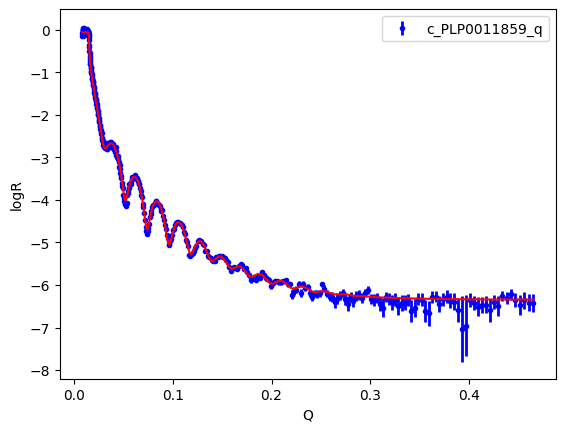

In [9]:
# an Objective has a plot method, which is a quick visualisation. You need
# matplotlib installed to create a graph
objective.plot()
plt.legend()
plt.xlabel('Q')
plt.ylabel('logR')
plt.legend()

In [15]:
from refnx.reflect._code_fragment import code_fragment
cf = code_fragment(objective)

with open("cf.py", 'w') as f:
    f.write(cf)

________________________________________________________________________________
Objective - 4733931824
Dataset = c_PLP0011859_q
datapoints = 408
chi2 = 920.5781637868356
Weighted = True
Transform = Transform('logY')
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=0.877287 +/- 0.00303, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=4.52059e-07 +/- 2.14e-08, bounds=[1e-09, 9e-06]>
<Parameter:'dq - resolution', value=5  (fixed) , bounds=[-inf, inf]>
<Parameter:  'q_offset'   , value=0  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:      'Si'      
<Parameter: 'Si - thick'  , value=0  (fixed) 

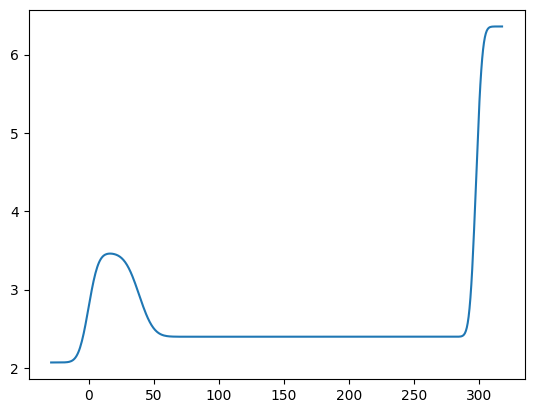

In [10]:
# Structure has a sld_profile method to return the SLD profile. Let's also plot that.
plt.plot(*structure.sld_profile())

# and print out the results of the fit. For the case of DifferentialEvolution uncertainties
# are estimated by estimating the Hessian/Covariance matrix
print(objective)

In [ ]:
# now lets do a MCMC sampling of the curvefitting system
# first we do 400 samples which we then discard. These samples are
# discarded because the initial chain might not be representative
# of an equilibrated system (i.e. distributed around the mean with
# the correct covariance).
fitter.sample(400)
fitter.reset()
# now do a production run, only saving 1 in 100 samples. This is to
# remove autocorrelation. We save 30 steps, giving a total of 30 * 200
# samples (200 walkers is the default).
res = fitter.sample(30, nthin=100, pool=4)

In [ ]:
# now let's look at the final output of the sampling. Each varying
# parameter is given a set of statistics. `Parameter.value` is the
# median of the chain samples. `Parameter.stderr` is half the [15, 85]
# percentile, representing a standard deviation.
print(objective)

In [ ]:
# a corner plot shows the covariance between parameters
objective.corner();

In [ ]:
# once we've done the sampling we can look at the variation in the model
# at describing the data. In this example there isn't much spread.
objective.plot(samples=100);

In [ ]:
# in a similar manner we can look at the spread in SLD profiles
# consistent with the data. The objective.pgen generator yields
# parameter sets from the chain.

# but first we'll save the parameters in an array.
saved_params = np.array(objective.parameters)

z, true_sld = structure.sld_profile()

for pvec in objective.pgen(ngen=500):
    objective.setp(pvec)
    zs, sld = structure.sld_profile()
    plt.plot(zs, sld, color='k', alpha=0.05)

# put back saved_params
objective.setp(saved_params)

plt.plot(z, true_sld, lw=1, color='r')
plt.ylim(2.2, 6)